In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cm2inch(value):
    return value/2.54

In [44]:
#plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (cm2inch(19),cm2inch(9))
plotsize_subplots = (7,7)

fontsize_axis = 9
fontsize_labels = 9
fontsize_legends = 8

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

In [4]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_vp"""
    
    # For MAM, T_conns is divided into T_network_global and T_connect:
    if 'T_conns_min' not in list(df) and 'T_network_global_min' in list(df): 
        df['T_conns_min'] = df['T_network_global_min'] + df['T_connect_min']
        df['T_conns_max'] = df['T_network_global_max'] + df['T_connect_max']
    
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():  # Population model
        # Population model does not simulate, VSize_mem is therefore equal to VSize_ini_sum as this is the
        # end of the benchmark
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df):  # MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']  # VSize_mem_sum is called VSize_net_sum for MAM
        df['VSize_nodes_sum'] = np.NaN  # MAM model does not have VSize_nodes_sum

    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)

    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per VP'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3

    return df

In [5]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45, one_row=True, logy=False,
                 color=None, plot_T_sim=True, plot_kind='bar', title=''):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per VP']
    if not index:
        index='N_VP'
    if plot_T_sim:
        df['Simulation time'] = df['T_sim']
        values.insert(3, 'Simulation time')
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)

    # Make subplots
    if one_row:
        fig, axes = plt.subplots(nrows=1, ncols=len(values))
        if len(values) == 1:
            axes = [axes]
                
        for indx, val_name in enumerate(values):
            df_p[val_name].plot(kind=plot_kind, ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot,
                                logy=logy, legend=False, color=color)
        axes[0].legend(fontsize=fontsize_legends, loc=legend_loc)
        
        plt.subplots_adjust(wspace=0.5)
    else:
        plotsize_subplots = (cm2inch(19),cm2inch(9))
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=plotsize_subplots)

        df_p['Conn. Creation (min)'].plot(kind='bar', ax = axes[0][0], title='Conn. Creation (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        axes[0][0].legend(fontsize=fontsize_legends, loc=legend_loc)
        df_p['Conn. Exchange (min)'].plot(kind='bar', ax = axes[0][1], title='Conn. Exchange (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        df_p['Conn. Total'].plot(kind='bar', ax = axes[1][0], title='Conn. Total', fontsize=fontsize_axis,
                                 rot=rot, legend=False)
        df_p['Memory per VP'].plot(kind='bar', ax = axes[1][1], title='Memory per VP', fontsize=fontsize_axis,
                                   rot=rot, legend=False)

        plt.subplots_adjust(wspace=0.5, hspace=0.7)

    # y-axis labels
    if 'Total Conn. Time per Conn.' in values:  
        axes[0].set_ylabel(r'Time [$\mu$s]')  # Not safe..
    else:
        if one_row:
            axes[0].set_ylabel('Time [s]')
        else:
            axes[0][0].set_ylabel('Time [s]')
            axes[1][0].set_ylabel('Time [s]')
    if 'Memory per VP' in values:
        # Assume memory is last entry in values
        if one_row:
            axes[len(values) - 1].set_ylabel('Memory [GiB]')
        else:
            axes[1][1].set_ylabel('Memory [GiB]')
    elif 'Memory per connection' in values:
        axes[len(values) - 1].set_ylabel('Memory [B]')

    # x-axis labels
    if one_row:
        for ax in axes:
            ax.set_xlabel(index)

    if title:
        fig.suptitle(title, y=1.2)
            
    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

Conn. Creation (min)                                                  \
Case          0 NEST 2.20 00 - a641eec1e GOOD 1 - 5998cb611 2 - f2a0565b4   
N_VP                                                                        
36                  47.47               56.66         55.85         56.91   
72                  47.47               56.59         55.71         56.43   
144                 47.41               57.06         55.87         57.00   
288                 47.67               57.37         56.45         57.25   
576                 47.48               58.23         57.32         58.00   
1152                47.59                 NaN           NaN         59.67   

                                                                           \
Case 3 - db126d18a 4 - 43ae44c5d 4 - master with change 5 - cfa213d05 BAD   
N_VP                                                                        
36           57.09         55.96                  70.65             76.53   
72           56.80         55.89                  70.76             76.13   
144          57.11         56.22                  71.56             73.96   
288          57.56         56.65                  71.36             74.96   
576          58.37         57.24                  72.89             74.55   
1152         59.86         58.90                    NaN             76.18   

                                                                          \
Case 5 - cfa213d05 with change 6 - 49cbf90f0 7 - fd68ec101 8 - d8cb2976b   
N_VP                                                                       
36                       56.94         79.91         75.83         74.88   
72                       57.06         79.20         75.34         76.57   
144                      57.48         79.93         75.79         74.86   
288                      58.02         76.47         75.10         73.68   
576                      58.73         77.59         74.58         74.42   
1152                     60.52         77.86           NaN           NaN   

                                     
Case 9 - c777c33 99 - 8f5a5fc1e BAD  
N_VP                                 
36         76.75              69.92  
72         77.24              72.80  
144        75.10              72.66  
288        74.50              71.04  
576        74.50              71.13  
1152         NaN                NaN

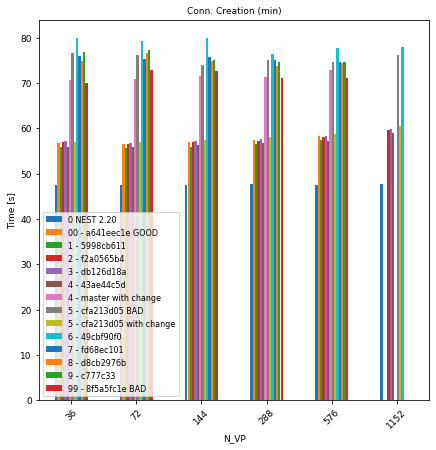

In [45]:
hpc_220 = pd.read_csv('results/hpc_benchmark_2_20_daint.csv')
hpc_220['Case'] = ['0 NEST 2.20'] * len(hpc_220)


hpc_3_a6 = pd.read_csv('results/hpc_benchmark_3_0_a641eec1e_daint.csv') # GOOD
hpc_3_a6['Case'] = ['00 - a641eec1e GOOD'] * len(hpc_3_a6)
hpc_3_8f = pd.read_csv('results/hpc_benchmark_3_0_8f5a5fc1e_daint.csv') # BAD
hpc_3_8f['Case'] = ['99 - 8f5a5fc1e BAD'] * len(hpc_3_8f)

# Bisect:
hpc_3_c7 = pd.read_csv('results/bisect/hpc_benchmark_bisect_c777c33_daint.csv')
hpc_3_c7['Case'] = ['9 - c777c33'] * len(hpc_3_c7)
hpc_3_d8 = pd.read_csv('results/bisect/hpc_benchmark_bisect_d8cb2976b_daint.csv')
hpc_3_d8['Case'] = ['8 - d8cb2976b'] * len(hpc_3_d8)
hpc_3_59 = pd.read_csv('results/bisect/hpc_benchmark_bisect_5998cb611_daint.csv')
hpc_3_59['Case'] = ['1 - 5998cb611'] * len(hpc_3_59)
hpc_3_f2 = pd.read_csv('results/bisect/hpc_benchmark_bisect_f2a0565b4_daint.csv')
hpc_3_f2['Case'] = ['2 - f2a0565b4'] * len(hpc_3_f2)
hpc_3_fd = pd.read_csv('results/bisect/hpc_benchmark_bisect_fd68ec101_daint.csv')
hpc_3_fd['Case'] = ['7 - fd68ec101'] * len(hpc_3_fd)
hpc_3_49 = pd.read_csv('results/bisect/hpc_benchmark_bisect_49cbf90f0_daint.csv')
hpc_3_49['Case'] = ['6 - 49cbf90f0'] * len(hpc_3_49)
hpc_3_db = pd.read_csv('results/bisect/hpc_benchmark_bisect_db126d18a_daint.csv')
hpc_3_db['Case'] = ['3 - db126d18a'] * len(hpc_3_db)

# problem:
hpc_3_cf = pd.read_csv('results/bisect/hpc_benchmark_bisect_cfa213d05_daint.csv')
hpc_3_cf['Case'] = ['5 - cfa213d05 BAD'] * len(hpc_3_cf)
hpc_3_cf_1 = pd.read_csv('results/bisect/hpc_benchmark_bisect_cfa213d05_1_daint.csv')
hpc_3_cf_1['Case'] = ['5 - cfa213d05 with change'] * len(hpc_3_cf_1)
hpc_3_cf_2 = pd.read_csv('results/bisect/hpc_benchmark_bisect_cfa213d05_2_daint.csv')
hpc_3_cf_2['Case'] = ['5 - cfa213d05 with change'] * len(hpc_3_cf_2)

# prev.
hpc_3_43 = pd.read_csv('results/bisect/hpc_benchmark_bisect_43ae44c5d_daint.csv')
hpc_3_43['Case'] = ['4 - 43ae44c5d'] * len(hpc_3_43)
hpc_3_c6 = pd.read_csv('results/bisect/hpc_benchmark_bisect_c690b7a3d_1_daint.csv')
hpc_3_c6['Case'] = ['4 - master with change'] * len(hpc_3_c6)

#cfa213d0586afa8224dd2cc932283ee597d500d4 is the first bad commit
#commit cfa213d0586afa8224dd2cc932283ee597d500d4
#Author: Stine Vennemo <stine.vennemo@gmail.com>
#Date:   Fri Sep 25 11:53:38 2020 +0200

#    restructure if/else and add provides_long() to ConnParameter

# nestkernel/conn_builder.cpp   | 148 ++++++++++++++----------------------------
# nestkernel/conn_parameter.cpp |   2 +
# nestkernel/conn_parameter.h   |  32 ++++++++-
# 3 files changed, 82 insertions(+), 100 deletions(-)


hpc = pd.concat([hpc_220,  hpc_3_a6, hpc_3_8f, hpc_3_c7, hpc_3_d8, hpc_3_59, hpc_3_f2,
                 hpc_3_fd, hpc_3_49, hpc_3_db, hpc_3_cf, hpc_3_cf_2, hpc_3_43, hpc_3_c6])

hpc = calculate_T_conn_and_memory(hpc)
values=['Conn. Creation (min)']
hpc_p = plot_compare(hpc, 'figures/bisect/hpc_benchmark_weak_scaling.pdf', values=values, plot_T_sim=False,
                     legend_loc='lower left')

hpc_p

Conn. Creation (min)                                         \
Case      3cae38a4b - fix 8f5a5fc1e BAD NEST 2.20 a641eec1e GOOD   
N_VP                                                               
36                  54.12         69.92     47.47          56.66   
72                  54.38         72.80     47.47          56.59   
144                 54.53         72.66     47.41          57.06   
288                 55.00         71.04     47.67          57.37   
576                 55.90         71.13     47.48          58.23   
1152                  NaN           NaN     47.59            NaN   

     Conn. Exchange (min)                                         \
Case      3cae38a4b - fix 8f5a5fc1e BAD NEST 2.20 a641eec1e GOOD   
N_VP                                                               
36                  79.30         79.20     51.06          77.80   
72                  81.31         81.26     54.56          80.93   
144                 82.17         81.98     56.86          80.88   
288                 85.92         84.68     63.50          85.66   
576                 89.89         89.41     79.77          89.80   
1152                  NaN           NaN    108.10            NaN   

         Conn. Total                                          Memory per VP  \
Case 3cae38a4b - fix 8f5a5fc1e BAD NEST 2.20 a641eec1e GOOD 3cae38a4b - fix   
N_VP                                                                          
36            135.62        158.72    100.88         145.19        2.887291   
72            138.40        169.13    106.29         150.17        2.893434   
144           139.28        166.18    108.38         149.15        2.978171   
288           143.41        169.43    113.49         156.76        2.984314   
576           148.40        176.24    131.74         161.55        3.066102   
1152             NaN           NaN    159.98            NaN             NaN   

                                            Simulation time                \
Case 8f5a5fc1e BAD NEST 2.20 a641eec1e GOOD 3cae38a4b - fix 8f5a5fc1e BAD   
N_VP                                                                        
36        2.886640  2.819082       2.890740          201.72        203.83   
72        2.892702  2.834828       2.893303          210.98        211.11   
144       2.978537  2.908171       2.980969          216.46        217.54   
288       2.983866  2.913480       2.983796          228.30        230.29   
576       3.074016  3.051638       3.068073          240.23        242.58   
1152           NaN  3.395655            NaN             NaN           NaN   

                               
Case NEST 2.20 a641eec1e GOOD  
N_VP                           
36      191.81         204.21  
72      199.87         207.42  
144     199.12         211.14  
288     212.72         225.03  
576     228.70         240.17  
1152    267.55            NaN

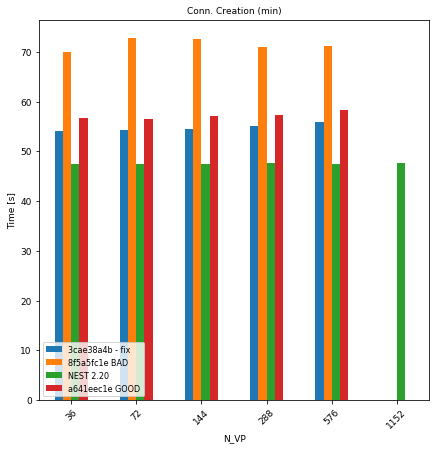

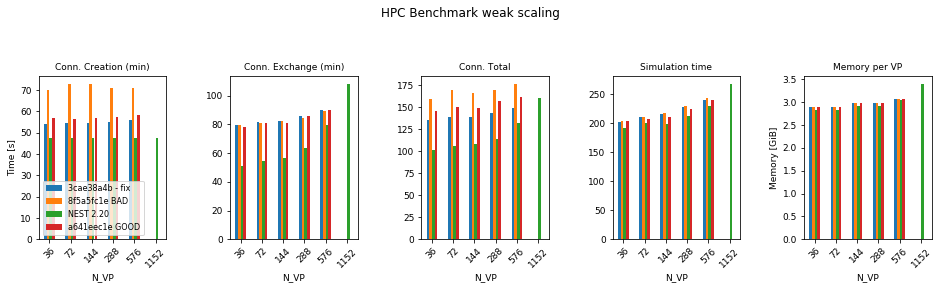

In [48]:
hpc_220 = pd.read_csv('results/hpc_benchmark_2_20_daint.csv')
hpc_220['Case'] = ['NEST 2.20'] * len(hpc_220)


hpc_3_a6 = pd.read_csv('results/hpc_benchmark_3_0_a641eec1e_daint.csv') # GOOD
hpc_3_a6['Case'] = ['a641eec1e GOOD'] * len(hpc_3_a6)
hpc_3_8f = pd.read_csv('results/hpc_benchmark_3_0_8f5a5fc1e_daint.csv') # BAD
hpc_3_8f['Case'] = ['8f5a5fc1e BAD'] * len(hpc_3_8f)

hpc_3_3c = pd.read_csv('results/bisect/hpc_benchmark_bisect_3cae38a4b_daint.csv')
hpc_3_3c['Case'] = ['3cae38a4b - fix'] * len(hpc_3_3c)

hpc_fix = pd.concat([hpc_220,  hpc_3_a6, hpc_3_8f, hpc_3_3c])

hpc_fix = calculate_T_conn_and_memory(hpc_fix)
values=['Conn. Creation (min)']
hpc_fix_p = plot_compare(hpc_fix, 'figures/bisect/hpc_benchmark_weak_scaling_connection_fix.png', values=values,
                         plot_T_sim=False,
                         legend_loc='lower left')

plotsize_subplots = (16,3)
plt.rcParams.update({'figure.figsize': plotsize_subplots})

hpc_fix_p = plot_compare(hpc_fix, 'figures/bisect/hpc_benchmark_weak_scaling_fix.png',
                         plot_T_sim=True,
                         legend_loc='lower left', title='HPC Benchmark weak scaling')

plt.rcParams.update({'figure.figsize': (7,7)})

hpc_fix_p

## FIND PROBLEM WITH `N_VP=1152`

Conn. Creation (min)                                      
Case          0 NEST 2.20 6 - 49cbf90f0 GOOD 99 - 8f5a5fc1e BAD
N_VP                                                           
36                  47.47              79.91              69.92
72                  47.47              79.20              72.80
144                 47.41              79.93              72.66
288                 47.67              76.47              71.04
576                 47.48              77.59              71.13
1152                47.59              77.86                NaN

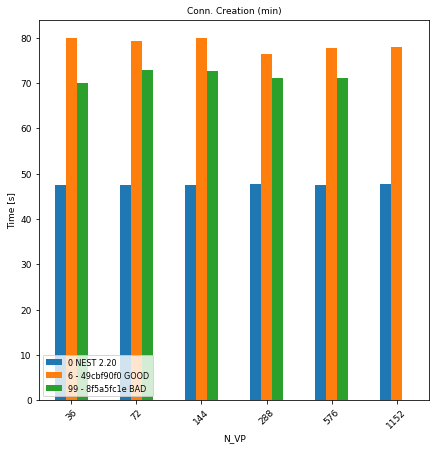

In [49]:
hpc_220 = pd.read_csv('results/hpc_benchmark_2_20_daint.csv')
hpc_220['Case'] = ['0 NEST 2.20'] * len(hpc_220)


hpc_3_49 = pd.read_csv('results/bisect/hpc_benchmark_bisect_49cbf90f0_daint.csv') # GOOD
hpc_3_49['Case'] = ['6 - 49cbf90f0 GOOD'] * len(hpc_3_49)
hpc_3_8f = pd.read_csv('results/hpc_benchmark_3_0_8f5a5fc1e_daint.csv') # BAD
hpc_3_8f['Case'] = ['99 - 8f5a5fc1e BAD'] * len(hpc_3_8f)

# Bisect:
#hpc_3_c7 = pd.read_csv('results/bisect/hpc_benchmark_bisect_c777c33_daint.csv')
#hpc_3_c7['Case'] = ['9 - c777c33'] * len(hpc_3_c7)


hpc_nvp = pd.concat([hpc_220,  hpc_3_49, hpc_3_8f])

hpc_nvp = calculate_T_conn_and_memory(hpc_nvp)
values=['Conn. Creation (min)']
hpc_nvp_p = plot_compare(hpc_nvp, 'figures/bisect/hpc_benchmark_weak_scaling_nvp.pdf',
                         values=values, plot_T_sim=False, legend_loc='lower left')

hpc_nvp_p